In [18]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Explore the data set

Number of training examples: 60000
Number of testing examples: 10000
Number of classes: 10
Image shape: (28, 28)
Image data type: uint8


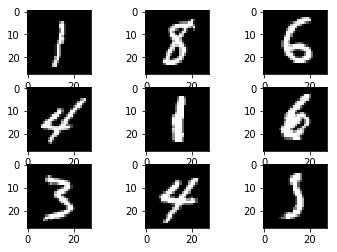

In [10]:
for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 123], cmap="gray")
num_classes = np.unique(y_train).shape[0]
print("Number of training examples:", x_train.shape[0])
print("Number of testing examples:", x_test.shape[0])
print("Number of classes:", num_classes)
print("Image shape:", x_train[0].shape)
print("Image data type:", x_train.dtype)

The data set consists of 60000 training examples and 10000 test examples. The data is 28x28 grayscale images of digits from 0-9, giving 10 classes.


<BarContainer object of 10 artists>

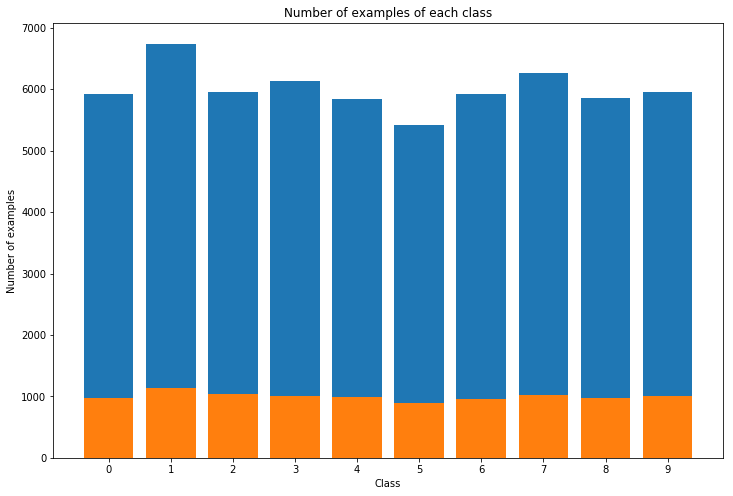

In [19]:
class_distribution_train = Counter(y_train)
class_distribution_test = Counter(y_test)
x = range(10)
train_y = [class_distribution_train[cls] for cls in x]
test_y = [class_distribution_test[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of examples of each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, train_y)
plt.bar(x, test_y)

The class distribution in the data set is fairly even, with a slight weight on the number 1, but this is probably because it is the most difficult number to recognize, as it contains few key features and can be written in several different ways.
The class distribution in the test set is representative of the distribution in the training set.

### Data pre-processing
#### Normalization of the data

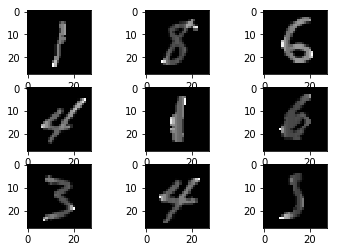

In [25]:
# Normalize the training data
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 123], cmap="gray")


#### Split training data into training and validation

In [27]:
train_val_split = 0.9 # Percentage of data to use in training set
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split * x_train.shape[0])]
idx_val = indexes[int(train_val_split * x_train.shape[0]):]

x_val = x_train[idx_val]
y_val = y_train[idx_val]

x_train = x_train[idx_train]
y_train = y_train[idx_train]

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Testing set shape:", x_test.shape)

Training set shape: (54000, 28, 28)
Validation set shape: (6000, 28, 28)
Testing set shape: (10000, 28, 28)


## Training the model

In [113]:
class TrainingParams:
    epochs = 10
    batch_size = 128
    optimizer = 'adam'
    loss = 'sparse_categorical_crossentropy'
    verbose = 1
    metrics = ['accuracy']
training_params = TrainingParams()

In [114]:
def train_model(model_spec, training_parameters):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten())
    model_spec(model)
    model.compile(optimizer=training_parameters.optimizer,
                  loss=training_parameters.loss,
                  metrics=training_parameters.metrics)

    model.fit(x_train, y_train,
              validation_data=(x_val, y_val),
              batch_size=training_parameters.batch_size,
              verbose=training_parameters.verbose,
              epochs=training_parameters.epochs)  # train the model

    return model

## Evaluate the model

In [54]:
def evaluate_model(model):
    model.summary()
    # evaluate the model using the test data
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("Test loss: %.4f, accuracy: %.4f" % (test_loss, test_acc))

def visualize_loss_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_loss"], label="Validation loss")
    plt.plot(history["loss"], label="Training loss")
    plt.legend()

def visualize_accuracy_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_acc"], label="Validation accuracy")
    plt.plot(history["acc"], label="Training accuracy")
    plt.legend()

## Models

#### Model 1:
| Layer Type | Hidden Units | Activation |
|------------|--------------|------------|
| Dense      | 128          | ReLU       |
| Dense      | 10           | SoftMax    |

In [42]:
def model_1(model):
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))

In [51]:
model = train_model(model_1, training_params)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 1s 26us/step - loss: 0.4588 - acc: 0.8817 - val_loss: 0.2545 - val_acc: 0.9303
Epoch 2/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.2182 - acc: 0.9374 - val_loss: 0.1970 - val_acc: 0.9455
Epoch 3/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.1653 - acc: 0.9528 - val_loss: 0.1686 - val_acc: 0.9522
Epoch 4/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.1311 - acc: 0.9622 - val_loss: 0.1443 - val_acc: 0.9585
Epoch 5/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.1086 - acc: 0.9685 - val_loss: 0.1267 - val_acc: 0.9628
Epoch 6/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.0914 - acc: 0.9732 - val_loss: 0.1213 - val_acc: 0.9653
Epoch 7/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.0786 - acc: 0.9774 - val_loss: 0.1093 - val_acc:

In [56]:
evaluate_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 24us/step
Test loss: 0.0945, accuracy: 0.9722


#### Model 2:
| Layer Type | Hidden Units | Activation |
|------------|--------------|------------|
| Dense      | 16           | ReLU       |
| Dense      | 10           | SoftMax    |


In [116]:
def model_2(model):
    model.add(keras.layers.Dense(16, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))

In [117]:
training_params.epochs = 40
model = train_model(model_2, training_params)

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 2s 29us/step - loss: 0.7988 - acc: 0.8032 - val_loss: 0.3872 - val_acc: 0.8972
Epoch 2/40
54000/54000 [==============================] - 1s 16us/step - loss: 0.3471 - acc: 0.9018 - val_loss: 0.3173 - val_acc: 0.9123
Epoch 3/40
54000/54000 [==============================] - 1s 16us/step - loss: 0.2996 - acc: 0.9146 - val_loss: 0.2908 - val_acc: 0.9203
Epoch 4/40
54000/54000 [==============================] - 1s 16us/step - loss: 0.2743 - acc: 0.9214 - val_loss: 0.2750 - val_acc: 0.9223
Epoch 5/40
54000/54000 [==============================] - 1s 16us/step - loss: 0.2544 - acc: 0.9266 - val_loss: 0.2579 - val_acc: 0.9297
Epoch 6/40
54000/54000 [==============================] - 1s 16us/step - loss: 0.2370 - acc: 0.9318 - val_loss: 0.2466 - val_acc: 0.9308
Epoch 7/40
54000/54000 [==============================] - 1s 17us/step - loss: 0.2233 - acc: 0.9352 - val_loss: 0.2341 - val_acc:

In [118]:
evaluate_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_59 (Dense)             (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 18us/step
Test loss: 0.1590, accuracy: 0.9541


In [119]:
def model_3(model):
    model.add(keras.layers.Dense(768, activation="relu"))
    model.add(keras.layers.Dropout(0.15))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dropout(0.10))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dropout(0.10))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(128, activation="sigmoid"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))

In [120]:
training_params.epochs = 20
model = train_model(model_3, training_params)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 7s 130us/step - loss: 0.3956 - acc: 0.8798 - val_loss: 0.1559 - val_acc: 0.9575
Epoch 2/20
54000/54000 [==============================] - 6s 111us/step - loss: 0.1275 - acc: 0.9618 - val_loss: 0.1118 - val_acc: 0.9657
Epoch 3/20
54000/54000 [==============================] - 6s 115us/step - loss: 0.0868 - acc: 0.9738 - val_loss: 0.1002 - val_acc: 0.9715
Epoch 4/20
54000/54000 [==============================] - 6s 113us/step - loss: 0.0658 - acc: 0.9805 - val_loss: 0.0921 - val_acc: 0.9747
Epoch 5/20
54000/54000 [==============================] - 6s 120us/step - loss: 0.0544 - acc: 0.9839 - val_loss: 0.0916 - val_acc: 0.9738
Epoch 6/20
54000/54000 [==============================] - 6s 114us/step - loss: 0.0447 - acc: 0.9870 - val_loss: 0.1004 - val_acc: 0.9742
Epoch 7/20
54000/54000 [==============================] - 6s 114us/step - loss: 0.0408 - acc: 0.9883 - val_loss: 0.0994 - v

In [121]:
evaluate_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 768)               602880    
_________________________________________________________________
dropout_12 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 512)               393728    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
__________

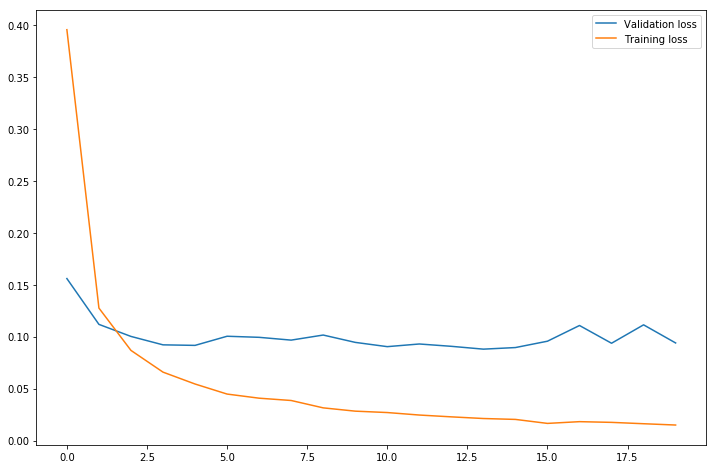

In [122]:
visualize_loss_history(model)

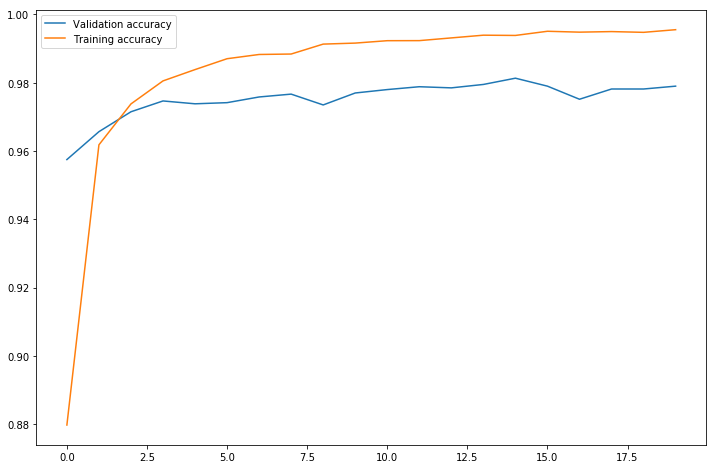

In [123]:
visualize_accuracy_history(model)